In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
torch.manual_seed(4701)
np.random.seed(4701)

# Load in model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    model_ft = torch.load('model-final')
else:
    model_ft = torch.load('model-final', map_location=torch.device('cpu'))
model_ft.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [2]:
# Constants
data_dir = '../../dataset/'
batch_size = 8
mean = [0.483152, 0.49999946, 0.46501586] # Found using calc_mean_std
std = [0.22492972, 0.22467473, 0.26939526] # Found using calc_mean_std

In [3]:
def preprocess_data():
    """
    Returns the transformation necessary to normalize the image data.

    Creates a normalization transformation that results in the training data
    having a mean of 0 and a standard deviation of 1.
    """
    
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200)
    ])

    # Creates a dataloader object for the training and validation sets
    train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), \
        transform)
    train_dataloader = torch.utils.data.DataLoader(train_dataset, \
        batch_size=batch_size, shuffle=True, num_workers=0)

    return transforms.Compose([
        transforms.ToTensor(),
        transforms.CenterCrop(200),
        transforms.Normalize(mean,std)
    ])

In [4]:
# Load in test set, retrieve class names
transformations = preprocess_data()
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transformations)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
classes = test_dataset.classes

In [5]:
def softmax(x):
    # Citation: https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    return np.exp(x) / np.sum(np.exp(x), axis=0)

In [6]:
# Determine the predicted versus actual labels & confidences for k images in the test set
def k_results(model, dataloader, k):
    results = []
    count = 0
    for data, label in dataloader:
        data = data.to(device)
        output = model(data)
        _, prediction = torch.max(output, 1)
        for i, (p, l) in enumerate(zip(prediction, label)):
            count += 1
            results.append((p.item(), l.item(), data[i].cpu().numpy(), softmax(output[i].cpu().detach().numpy())))
            if count == k:
                return results 
    return results

In [7]:
# Ensure images are reverted back to normal before displaying
def unnormalize(img, mean, std):
    img = copy.deepcopy(img)
    for i in range(img.shape[-1]):
        assert (i <= 2)
        img[:, :, i] *= std[i]
        img[:, :, i] += mean[i]
    return img

In [8]:
# Generate the visual output for k testing images
def display_k_results(k, results):
    fig, axs = plt.subplots(4, 4)
    fig.set_size_inches(25, 25)
    for i in range(k):
        predicted = results[i][0]
        actual = results[i][1]
        axs[i//4, i % 4].set_title('Predicted: {} ({:.1f}% confidence)\nActually: {} ({:.1f}% confidence)'.format(
            classes[predicted],
            results[i][3][predicted]*100,
            classes[results[i][1]],
            results[i][3][actual]*100
            ))
        axs[i//4, i % 4].imshow(unnormalize(results[i][2].transpose(1, 2, 0), mean, std))
    fig.show()

/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


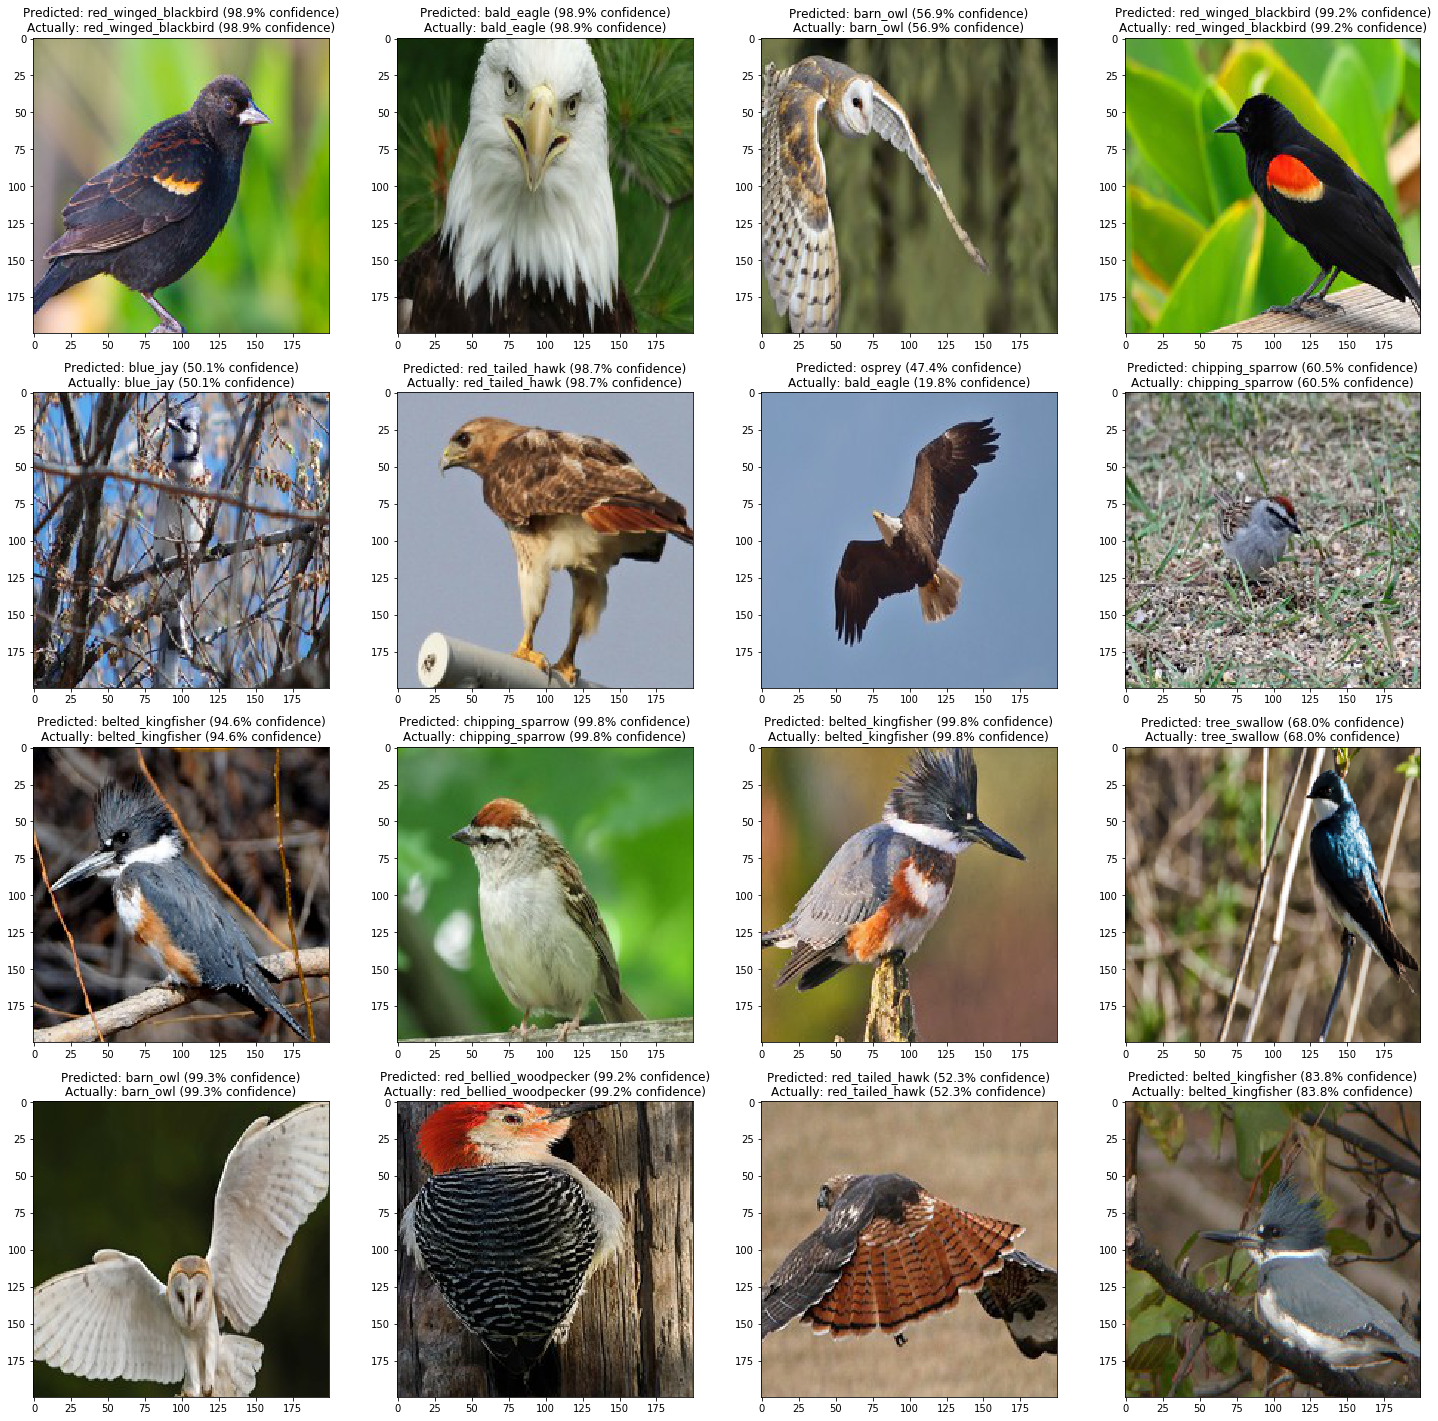

In [23]:
# Reveal our model's predictions on k birds from the test set
k = 16
results = k_results(model_ft, test_dataloader, k)
display_k_results(k, results)